In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython import display
from torchvision.utils import save_image, make_grid

### dataset

In [2]:
img_size = 28 # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в нашей картинке
batch_size = 64 # размер батча
img_shape = (channels, img_size, img_size) # полный шейп нашей картинки

real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

img_shape = (1, 28, 28)
lable_shape = torch.Size([])
img_shape after squeeze = (28, 28)


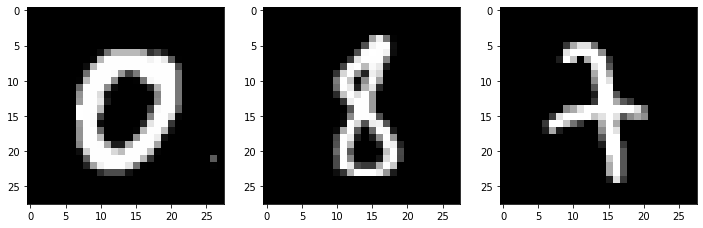

In [3]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'lable_shape = {labels[0].size()}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

### random noize

In [5]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

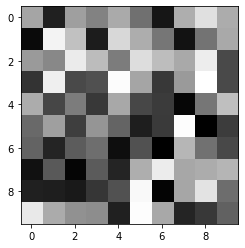

In [6]:
a = random_noise_generator(64, 100)
b = a[2]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_bn(x)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_bn(x)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [9]:
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [10]:
generator = Generator().float().to(device)
discriminator = Discriminator().float().to(device)

In [11]:
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam
gen_input_size = 100
epochs = 20

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch  0 : Discriminator Loss =  tensor(0.0443, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(8.9921, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  1 : Discriminator Loss =  tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(11.1900, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  2 : Discriminator Loss =  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(11.0234, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  3 : Discriminator Loss =  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(12.3679, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  4 : Discriminator Loss =  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(12.9755, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  5 : Discriminator Loss =  tensor(6.1432e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(14.0805, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  6 : Discriminator Loss =  tensor(3.8806e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(15.2494, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  7 : Discriminator Loss =  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(15.8339, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  8 : Discriminator Loss =  tensor(1.2262e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(15.8371, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  9 : Discriminator Loss =  tensor(0.0536, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(13.8593, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  10 : Discriminator Loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(13.5439, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  11 : Discriminator Loss =  tensor(7.2371e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(15.4666, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  12 : Discriminator Loss =  tensor(0.0355, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(14.4407, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  13 : Discriminator Loss =  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(12.0101, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  14 : Discriminator Loss =  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(13.7618, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  15 : Discriminator Loss =  tensor(8.4043e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(13.8768, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  16 : Discriminator Loss =  tensor(4.0503e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(15.4822, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  17 : Discriminator Loss =  tensor(2.8327e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(17.0935, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  18 : Discriminator Loss =  tensor(1.1860e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(18.6171, device='cuda:0', grad_fn=<DivBackward0>)


0it [00:00, ?it/s]

Epoch  19 : Discriminator Loss =  tensor(5.0807e-06, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(18.8920, device='cuda:0', grad_fn=<DivBackward0>)


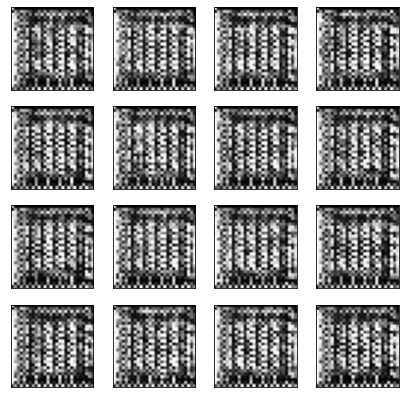

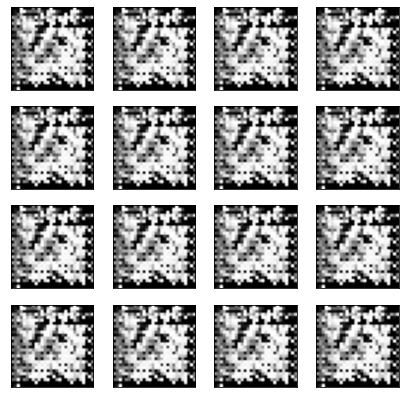

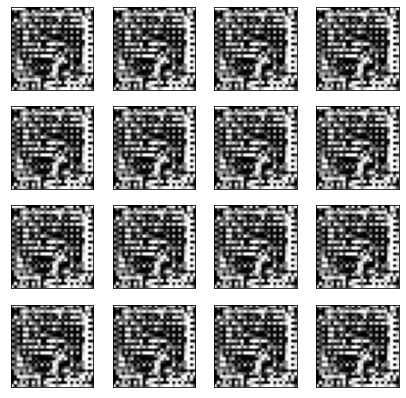

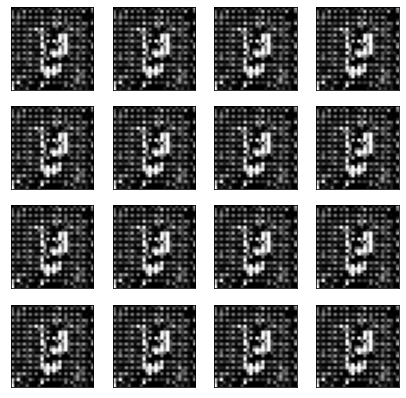

In [12]:
from tqdm.notebook import tqdm
d_loss_history = []
g_loss_history = []

sample_size = 16
fixed_samples = random_noise_generator(sample_size, gen_input_size)
fixed_samples = fixed_samples.to(device)
    
#Going into training mode
discriminator.train()
generator.train()

for epoch in tqdm(range(epochs)):

    disc_loss_total = 0
    gen_loss_total = 0
    gen_out = 0

    for i, (train_x, labels) in tqdm(enumerate(real_data)):

        #Discriminator training
        optimizer_D.zero_grad()

        train_x = train_x*2 - 1          
        train_x = train_x.to(device)
        real_out = discriminator(train_x.float())    

        disc_gen_in = random_noise_generator(batch_size, gen_input_size)
        disc_gen_in = disc_gen_in.to(device)
#         print(disc_gen_in.size())

        disc_gen_out = generator(disc_gen_in.float()).detach()  
        fake_out = discriminator(disc_gen_out.float())

        disc_loss = discriminator_loss(real_out, fake_out)
        disc_loss_total += disc_loss
        disc_loss.backward()
        optimizer_D.step()  

        #Generator training
        optimizer_G.zero_grad()


        gen_out = generator(disc_gen_in.float())     
        gen_disc_out = discriminator(gen_out.float())      

        gen_loss = generator_loss(gen_disc_out) 
        gen_loss_total += gen_loss
        gen_loss.backward()
        optimizer_G.step()

    d_loss_history.append(disc_loss_total)
    g_loss_history.append(gen_loss_total)

    #Plotting samples
    if epoch%5 == 0:
        generator.eval()                    
        samples = generator(fixed_samples.float())
        generator.train()                   

        fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples):
            img = img.cpu().detach()
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


    #Printing losses every epoch
    print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(real_data), ", Generator Loss = ", gen_loss_total/len(real_data))    
